# Demo: Baby Example with the Metropolis-Hastings Algorithm for Markov Chain Monte Carlo Sampling 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo, we explain what "sampling a probability distribution" means, and why someone would want to do it. From there, we introduce the most naive (but still decently effective) technique for sampling: the **Metropolis-Hastings (MH)** algorithm. MH is a particular type of **Markov chain Monte Carlo (MCMC)** method, and we'll investigate more sophisticated variants in future demos. We conclude by demonstrating a toy example with real code, showing how MH can be used to sample a normal distribution.  

## Suggested References

- Oliver Buhler, *A Brief Introduction to Classical, Statistical, and Quantum Mechanics*, AMS Courant Lecture Notes Series, 2006 (the relevant portion of this source for MH is section 3.10)

- Persi Diaconis, "The Markov Chain Monte Carlo Revolution", Bull. AMS, 2009. 

- Roger Peng's lecture notes, https://bookdown.org/rdpeng/advstatcomp/metropolis-hastings.html (most of our discussion is based off this source)

## What is Sampling and Why Do We Care? 

Let $\Omega\subseteq \mathbb{R}^{N}$. Given a probability distribution $f(x)$ defined over $\Omega$, a **sample** of $f(x)$ is a point $X\in \Omega$ that is randomly selected based on how big or small $f(X)$ is: the larger $f(X)$, the bigger chance $X$ will be selected. Loosely, for any $X\in \Omega$, the probability $P$ of selecting a point within a hypercube centred at $X$ with side length $\epsilon\ll 1$ is
$$
P\approx \rho(X) \ \epsilon^{N}. 
$$
When we draw a sequence of samples $X_{1}, ..., X_{N}$, we expect their density to be reasonably close to $f(x)$ when $N\gg 1$. Therefore, sampling gives us a way to approximate probability distributions. Of course, we have not yet said how sampling can actually be done!

Now, in probabilistic modelling or data science, computation of expected values is essential; indeed, the expectation is the easiest number we can use to summarize the behaviour of a random variable. Recall that, for a continuous real random variable $\phi(x)$ distributed according to $f(x)$, we have 
$$
\text{expectation of} \ \phi = \left\langle \phi\right\rangle = \int_{\Omega} \phi(x) \ f(x) \ \mathrm{d} x.
$$
So, computing expectations is the same as computing weighted integrals. Naively, then, we can numerically approximate $\left\langle \phi\right\rangle$ using a suitable quadrature rule. However, sampling provides an easier path. If we take very many samples $X_{1}, ...., X_{N}$ from $f(x)$, then as discussed above their density should be a good approximation of $f(x)$. Accordingly, we ought to have
$$
\left\langle \phi\right\rangle\approx \langle\phi\rangle_{N} =  \frac{1}{N}\sum_{n=1}^{N}\phi\left(X_{n}\right). 
$$
Indeed, the laws of large numbers show that $\approx$ can be replaced with $=$ in the limit $N\rightarrow\infty$. This is so simple it hurts! 

Similarly, we can use sampling to approximate higher-order statistics. For example, in the above notation we expect to have
$$
\text{Var} \phi = \left\langle \left(\phi-\left\langle\phi\right\rangle\right)^2\right\rangle \approx  \frac{1}{N}\sum_{n=1}^{N}\left(\phi\left(X_{n}\right)-\langle\phi\rangle_{N} \right)^2. 
$$

## The Metropolis-Hastings Algorithm

Now that we're convinced sampling is an easy way to approximate the statistics of a given distribution $f(x)$, we turn towards implementing it in practice. We focus on the easy MH algorithm. This essentially amounts to performing a random walk in data space, with the proviso that any steps that appear to be too unlikely according to $f(x)$ are rejected. Owing to the universality of random walks (which always make sense on vector spaces, lattices, groups, graphs,...), such an approach is the simplest one possible. 

To use MH, we need the following two requirements to be satisfied:

1) For any $x$, we must be able to evaluate $f(x)$ numerically, at least up to a normalization factor. 

2) We must have available a routine for sampling from uniform distributions on compact intervals $[a,b]$. Of course, every modern numerical software package comes with such a random number generator. 

Once we know the above two assumptions are satisfied, we choose an arbitrary initial sample $X_{0}$. If the distribution is symmetric about $x_{*}$, then $X_{0}=x_{*}$ is a good choice, but you can also choose $X_{0}$ uniformly randomly if you wish. Following that, assuming we inductively know $X_{n}$, $X_{n+1}$ is computed according to the recipe below. 

1) Fix a parameter $h>0$. Randomly choose an increment $\delta X \sim \text{Unif}[-h,h]$ and define a candidate sample $Y$ by 
$$
Y = X_{n} +\delta X. 
$$

2) Define 
$$
\alpha = \min\left\{1,\frac{f\left(Y\right)}{f\left(X_{n}\right)}\right\}
$$
and accept the step with probability $\alpha$. Since $\alpha$ is invariant under scalings of $f$, this is why we only need to know $f$ up to some normalization factor. 

4) If the step was accepted, set $X_{n+1}= Y$. Otherwise, set $X_{n+1}=X_{n}$. 

MH is delightfully easy to understand and to implement, but of course simplicity always comes at a price. In particular, the purely random exploration of our distribution means that MH can be extremely slow in obtaining a density of samples that approximates $f(x)$ nicely. Readers with a background in PDEs may understand this by recalling that that diffusion, the macroscopic manifestation of random walks, tends to make itself known only over long time scales. Below, we can produce some numerical evidence of this slow convergence, and in future demos we describe a method for adding extra structure to a given distribution that allows us more exotic ways of moving around the data space. 

## Code Example: MH Sampling of a Univariate Normal Distribution 

For this introductory demo we keep things simple, drawing samples from the normal distribution with standard deviation $\sigma$:
$$
f(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac12\left(\frac{x}{\sigma}\right)^2\right). 
$$

We start by specfiying the particular $\sigma$ we care about, and define a function that computes $f(x)$ while ignoring the normalization constant. 

In [2]:
sigma = 1. # standard deviation of our distribution

def f(x): # un-normalized normal distribution with std dev sigma
    return np.exp((-0.5/sigma**2)*x**2)

Next, we create a function that performs the MH algorithm to create (user-specified) $N$ samples from $f(x)$. 

In [3]:
def mh_gaussian_sampling(x0 = 0.0, h=5e-1, N=1e4):
# x0 = initial guess

# h = maximum step size

# N = number of samples 

    x = np.zeros(N, dtype=float) # vector storing samples 
    
    # use initial guess
    x[0]= x0
    
    # initialize rejection counter
    rejected = 0. 
    
    # set timer
    start = time.time()

    for t in np.arange(1,N):
        
        # randomly select step size
        increment = np.random.uniform(low=-h,high=h) 
        
        # note: the above seems to work a lot better than using a "true" (2-state Bernoulli)
        # random walk with fixed step size! 
    
        # tentative next guess
        y = x[t-1] + increment
    
        alpha = f(y)/f(x[t-1])
    
        u = np.random.uniform(low=0., high=1.)

        if u <= alpha:
        
            x[t] = y
                    
        elif u > alpha:
    
            x[t] = x[t-1]
        
            rejected += 1
    
    rej_ratio =  rejected/N 
            
    print('Rejection Ratio for' , N, 'samples = %.4f' % rej_ratio) 
    
    end = time.time()
    
    runtime  = end - start
    
    print('Runtime for' , N, 'samples = %.2f' % runtime, 'seconds')
            
    return x 

We test the performance of our method by checking how well it approximates the mean and variance of $f(x)$ for various values of $N$. Recall that the exact answers are 
\begin{align*}
\text{mean} &= \left\langle x\right\rangle  = 0
\\
\text{variance} &= \left\langle \left(x - \left\langle x\right\rangle\right)^2\right\rangle  = \sigma^2. 
\end{align*}

In [4]:
sizes = np.logspace(2,4,7).astype(int)

num_sizes= np.shape(sizes)[0]

num_trials = int(1e0) # number of elements of our ensemble TODO: how to improve
# performance using ensembles, or make sense of ensemble averages? 

mean_errors = np.zeros(num_sizes, dtype=float)

var_errors = np.zeros(num_sizes, dtype=float)

# make an intial guess, either the origin or a random guess in the 65% confidence interval
x0 = 0.0 #np.random.uniform(low=-sigma, high=sigma)

for n in np.arange(num_sizes):
    
    N = sizes[n]
    
    ensemble = np.zeros([num_trials,N], dtype=float)
    
    for m in np.arange(0,num_trials):
    
        ensemble[m,:] = mh_gaussian_sampling(x0, h=5e-1, N=N)
        
    x = ensemble.reshape(N*num_trials)
    
    mean_guess = np.abs((1./(N*num_trials))*np.sum(x))
    
    mean_errors[n] = mean_guess
    
    var_errors[n] = np.abs((1./(N*num_trials))*np.sum((x-mean_guess)**2)-sigma**2)

Rejection Ratio for 100 samples = 0.1000
Runtime for 100 samples = 0.00 seconds
Rejection Ratio for 215 samples = 0.0837
Runtime for 215 samples = 0.00 seconds
Rejection Ratio for 464 samples = 0.1013
Runtime for 464 samples = 0.01 seconds
Rejection Ratio for 1000 samples = 0.0880
Runtime for 1000 samples = 0.01 seconds
Rejection Ratio for 2154 samples = 0.1003
Runtime for 2154 samples = 0.03 seconds
Rejection Ratio for 4641 samples = 0.1047
Runtime for 4641 samples = 0.06 seconds
Rejection Ratio for 10000 samples = 0.0964
Runtime for 10000 samples = 0.13 seconds


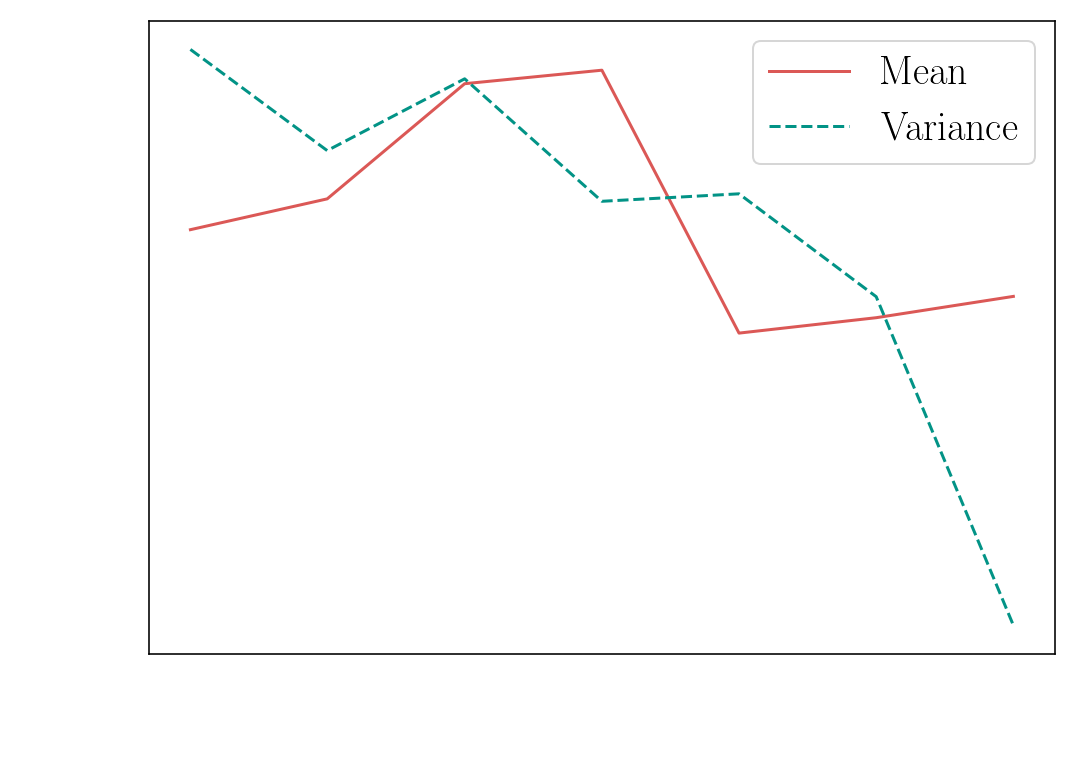

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.loglog(sizes, mean_errors, color='xkcd:pastel red', linestyle='solid')
plt.loglog(sizes, var_errors, color='xkcd:teal', linestyle='dashed')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.legend(['Mean', 'Variance'], loc='best', fontsize=20)

plt.xlabel(r"Sample Size $N$", fontsize=30, color = 'w')
plt.ylabel(r"Errors", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

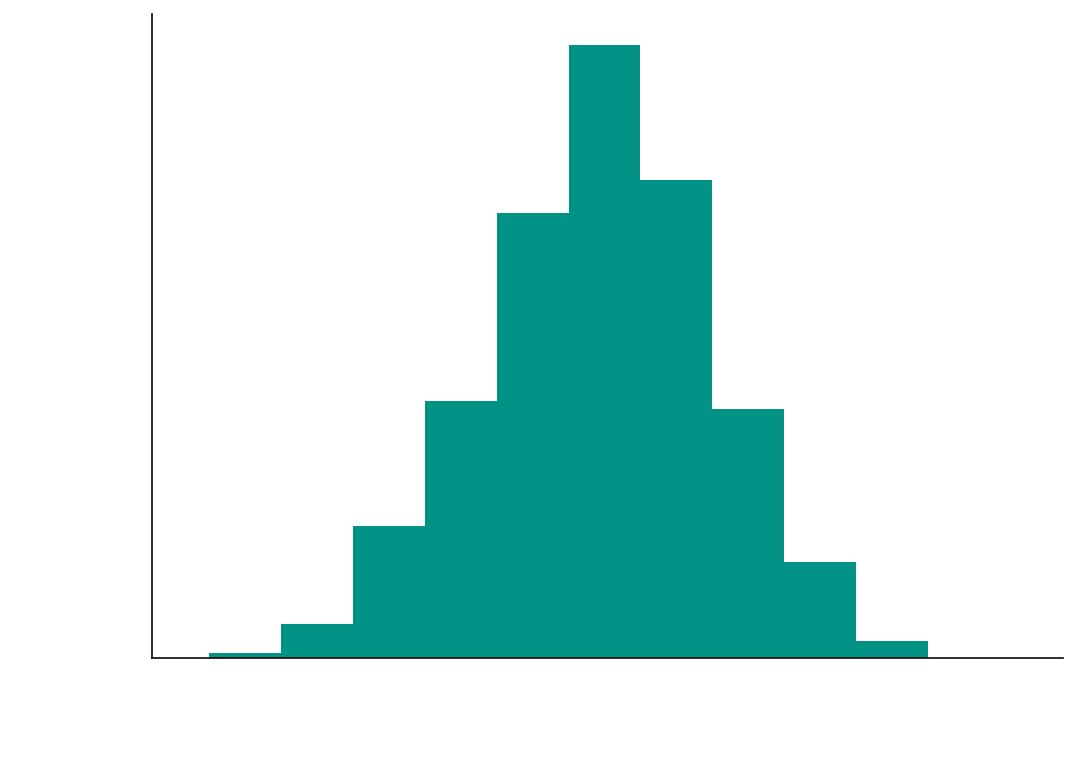

In [6]:
fig=plt.figure()
ax = fig.add_subplot(111, frameon=True)

plt.hist(x, color='xkcd:teal')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.xlabel(r"Position $x$", fontsize=30, color = 'w')
plt.ylabel(r"Number of Samples", fontsize=30, color = 'w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')

plt.tight_layout()

plt.xlim([-4,4]) # note: this sometimes produces useless white space on one side of the 
# histogram, which is usually a big no-no for nice figure presentation! But in the next
# demo we find there's a method in such madness. 

fig.set_size_inches(8, 6)
#plt.rcParams['figure.dpi'] = 600

#"""
plt.show()

The following discussion applies to the default case $h=2\times 10^{-1}$. Typically I have found that the errors in the mean and variance wiggle around pretty dramatically, but generally stay on the order of $10^{-1}$. This is good, but not great (though can we hope for greatness with such a simple scheme?). We see the root cause of why the accuracy is not so hot when we plot the histogram of the sampling with the highest $N$: for me, it almost always appears that the parity of the histogram is skewed to one side or the other (it lacks the symmetry of the true Gaussian function $f(x)$). This is a manifestation of a warning I gave earlier: random walks are slow, and in particular too slow to explore enough of the data space in these numerical examples! By increasing $N$ in the code above, the reader can check that I'm not just full of garbage, and eventually we do get a more symmetric histogram around $N=10^5$. 

The discussion in this cell applies to the more optimized case $h=1$ (check it!). This gives slightly better error curves and a much more even histogram. Of course, the discussion in the previous cell tells us why we expect better performance here: we're allowing ourselves to take bigger steps! The other lesson to take away from this observation is that algorithm parameters can be very fussy, but sometimes taking the time to massage them a bit can be worth it for the performance gain. 

Strictly speaking, all these plots are pretty artificial in the sense that in practice we want to keep $N$ as small as possible. In other words, the sampling routine should automatically detect when it's gone far enough and stop. We won't discuss convergence/stopping criteria here, but see Peng's notes for some insights: https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html

Finally, I should briefly say why MH falls under the umbrella of "Markov chain Monte Carlo methods". The idea is roughly that the random walk MH used to get samples constitutes a Markov chain, and by running the algorithm for more and more iterations we're (hopefully) getting close to the stationary distribution of that Markov chain, which (hopefully) should be $f(x)$. If all this talk of Markov chains and stationarity is over your head, have a look at Buhler's book. For more details on Markov chains in the context of MH (including a beautiful motivating example from cryptography), see Diaconis' excellent survey article. 